## Project Overview

<img src="https://th.bing.com/th/id/R.f32f6c0a36b1166033122544cf0dd8a1?rik=QmYumf41lwVQgA&pid=ImgRaw&r=0" style='margin-top:30x; margin-bottom:30px'/>
It is almost impossible for a person to attempt to consume all the products and choices available. It is even most likely that a person will not have the time, patience or resources to even view the myraids of choices in terms of products and services available at his disposal. Hence, it becomes almost imperative for producers of goods and services to help narrow down the choices of products presented to their users in an attempt to reduce overwhelming them and help them reach thier relevant products and services without waste of time and as a result, helping them have a better user experience, while also exposing them to more products and services they might have never discovered otherwise. This help comes in the form of  <b> recommendation </b>

Simple as the above sounds, it is not as easy to implement because the traditional approach would have been to deploy product recommender agents (like customer service representatives) who will handle recommendation requests from customers. But these agents will be unable to learn about every of thier customers and what products and services they might want and find useful. So how does one recommend products and services to people he does not know?

The response is using Recommender Systems. Recommender systems are machine learning systems that help users discover products and services based on the relationship between the users and the products.Recommender systems are like salesmen who have learnt to recognize customers and the products they might like based on their history and preferences. Recommender systems are so common place now that every time you shop online, a  recommendation system is guiding you towards the most likely product you might purchase.

There are several use cases of the recommender system. But this project will focus on movie recommendation.

---

## 1.0 Project Objective

To build a recommendation system capable of recommending movies to users and predicting ratings a user might give a movie they have never seen bebfore. <br ><br>

## 2.0 Packages

### 2.1. Installing Packages

For this project, two major libraries were leveraged on - sklearn and surprise. Sklearn is the most mopular of the two.

In [107]:
!pip install scikit-surprise

- <a href="http://surpriselib.com/"> Surprise</a> is a Python scikit for building and analyzing recommender systems that deal with explicit rating data. It does not support implicit ratings or content-based information. Surprise was used in this project to make collaborative prediction. <br>

### 2.2 Importing Packages 

In [108]:
# data loading and preprocessing 
import numpy as np 
import pandas as pd 
import pickle as pkl
from collections import Counter
from surprise import Reader
from surprise import Dataset
import math

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# feature extration and similarity metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

#modeling and validation
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

<br />

## 3.0 Loading Datasets

    
The dataset used for this project is the MovieLens dataset maintained by the GroupLens research group in the Department of Computer Science and Engineering at the University of Minnesota. Additional movie content data was legally scraped from IMDB. The dataset can be found <a href="https://www.kaggle.com/competitions/edsa-movie-recommendation-2022/data"> here</a>. Pandas library will be used to access and Manipulate the datasets.

In [109]:
# read movie dataset
df_movies = pd.read_csv('movies.csv')

In [110]:
# read the ratings dataset
df_rating = pd.read_csv('train_resized.csv')

In [111]:
# read the movie additional information
df_meta = pd.read_csv('imdb_data.csv')

<br><br>
## 4.0 Exploratory Data Analysis


Exploratory data analysis is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. Primarily, EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task.This approach for data analysis uses many tools(mainly graphical to maximize insight into a data set, extract important variables, detect outliers and anomalies, amongst other details that is missed when looking at DataFrame. This step is very important especially when we model the data in order to apply Machine Learning techniques. <br><br>

### 4.1 Overview of Our Datasets

The datasets for this project are eight. A brief overview is available <a href="https://www.kaggle.com/competitions/edsa-movie-recommendation-2022/data"> here</a>. For the purose of this project, we will be looking at three of those dataset (already imported above) which our models will most likely be relying on. 

### 4.2 Movie Ratings

We explore the scale, the distribution, ratings by movies, ratings by genre, average movie rating etc <br>

#### 4.2.1 Ratings Distribution

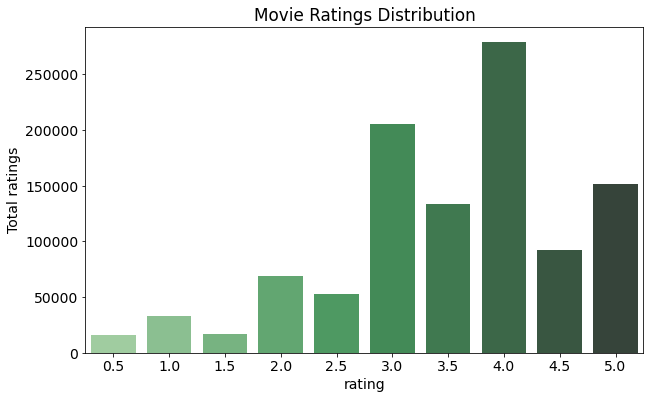

In [112]:
fig, ax = plt.subplots(figsize = (10, 6))
sns.countplot(data=df_rating, x='rating', ax=ax, palette="Greens_d")
plt.title('Movie Ratings Distribution')
plt.ylabel("Total ratings")
plt.show()

Most of the movies are rated above average. The Top three most common ratings are 3.0, 4.0 and 5.0. Generally, the ratings for movies has been good as the chart skews to the left. A look at the chart, we can observe that users prefer to rate movies in integers say 3 than thier float say 3.5. For an instance 1.0 is more frequent than 1.5, 2.0 than 2.5, 3.0 than 3.5 and goes all the way.

#### 4.2.2 Most rated Movies

In [113]:
font = {'family':'normal',
       'size':14}

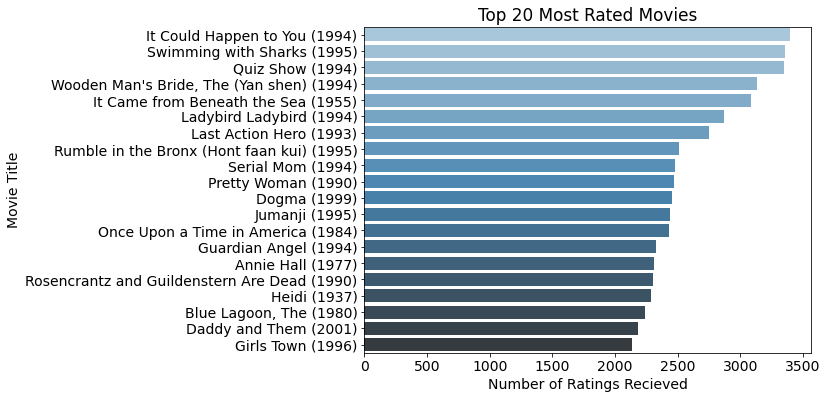

In [114]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.rc('font', **font)
data = df_rating['movieId'].value_counts().sort_values(ascending=False)[0:20]
titles = [df_movies.loc[movieId, 'title'] for movieId in data.index]
sns.barplot(y=titles, x=data, ax=ax, palette="Blues_d")
plt.title('Top 20 Most Rated Movies')
plt.ylabel("Movie Title")
plt.xlabel("Number of Ratings Recieved")
plt.show()

The most rated movies are movies produced in the 90's. Although, these chart does not determine if the movies are positevly or negatively rated. It only shows the total number of ratings they are able to garner. The question is, which movies are best rated.

#### 4.2.3 Best Rated Movies

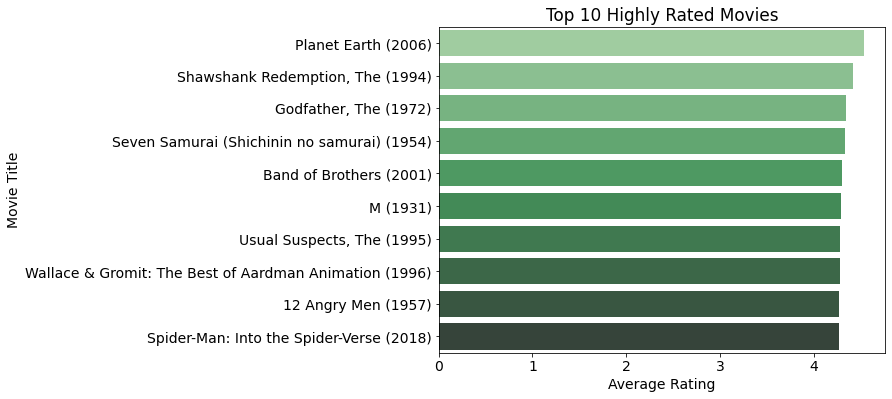

In [115]:
def most_popular(start, stop):
    # filter out movies with less than 50 ratings
    movies_per_rating = dict(Counter(df_rating.movieId))
    required_movies = []
    for key, value in movies_per_rating.items():
        if value > 50:
            required_movies.append(key)
    data = df_rating[df_rating['movieId'].isin(required_movies)]

    # calculating the average rating
    data = data.groupby('movieId')['rating'].mean().sort_values(ascending=False)[start:stop]
    return data

data = most_popular(0,10)

# ploting the 
fig, ax = plt.subplots(figsize = (8, 6))
plt.rc('font', **font)
index = [df_movies[df_movies['movieId'] == x].index for x in data.index]
titles = [df_movies[df_movies['movieId'] == movieId]['title'].iloc[0] for movieId in data.index]
sns.barplot(y=titles, x=data.values, ax=ax, palette="Greens_d")
plt.title('Top 10 Highly Rated Movies')
plt.ylabel("Movie Title")
plt.xlabel("Average Rating")
plt.show()

The result of the best rated movies points to the possibility that the best rated movies share genres in common. In fact, the best and second best movies where parts I and II of Planet Earth (same movie). From the title of the movies, one can make a blind guess that movies ranked top are between action, adventure and triller genres. We explore the common genres of the top rated movies.  

#### 4.2.3 Does Genre affect the rating of a movie

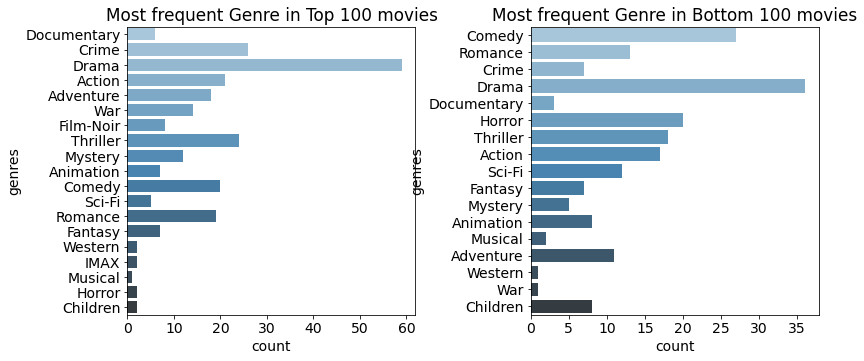

In [105]:
# checking the most popular genres in the top n movies with highest average rating
# Distribution of words per Class
fig, ax = plt.subplots(1,2, figsize=(12,5))

all_genres = []
data = most_popular(0, 100)
genres = [df_movies[df_movies['movieId'] == movieId]['genres'].iloc[0] for movieId in data.index]
genres = [all_genres.extend(x.split("|")) for x in genres if x != '(no genres listed)']
genres = pd.DataFrame({"genres":all_genres})
sns.countplot(y='genres', data=genres, palette='Blues_d', ax=ax[0])
ax[0].set_title("Most frequent Genre in Top 100 movies")

all_genres = []
data =  df_rating.groupby('movieId')['rating'].mean().sort_values()[0:100]
genres = [df_movies[df_movies['movieId'] == movieId]['genres'].iloc[0] for movieId in data.index]
genres = [all_genres.extend(x.split("|")) for x in genres if x != '(no genres listed)']
genres = pd.DataFrame({"genres":all_genres})
sns.countplot(y='genres', data=genres, palette='Blues_d', ax=ax[1])
ax[1].set_title("Most frequent Genre in Bottom 100 movies")

font1 = {'size':10}
plt.subplots_adjust(left=0.1,
                bottom=0.1, 
                right=0.9, 
                top=0.9, 
                wspace=0.4, 
                hspace=0.4)
plt.rc('font', **font1)
plt.show()

The genres of movies as a stand alone featrure has very little deterministic power on the ratings of the movie. Both the distribution of the top 100 and bottom 100 rated movies bears similar distribution. They contain almost same genres with similar frequencies 

#### 4.2.3 What year or seasons were the highest ratings given

In [12]:
def extract_year(title):
    year = title.split('(')
    if len(year) > 1:
        try:
            year = int(year[1][0:4])
            if year > 1500:
                return year
        except:
            pass
    

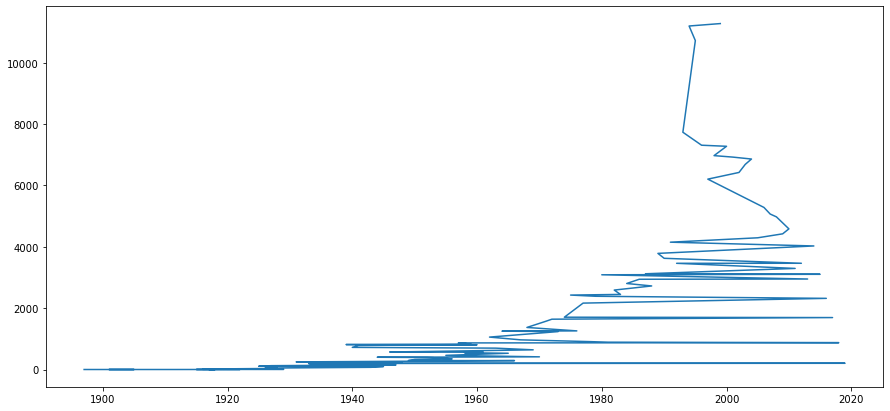

In [13]:
fig, ax = plt.subplots(figsize=(15, 7))
df_movies_high = df_rating[df_rating['rating'] >= 4.5]
movie_id_high = df_movies_high['movieId']
movie_title = df_movies.merge(movie_id_high)['title']
movie_date = movie_title.apply(extract_year)
movie_date = movie_date.value_counts()
movie = pd.DataFrame({'date':movie_date.index, 'count':movie_date.values})
movie['date'] = movie['date'].astype('int64')
movie['date'] = movie['date'].map(lambda x: pd.to_datetime(f'{x}-01-01'))
plt.plot(movie['date'], movie['count'])

from the timeseries plot, most movies rated 4.5 and above are majorly produced in the 1990s and and the early 2000s. movies produced in these year range have a higher probability of being rated in the class of 4.5 and above than movies produced in earlier years. Hence, the year of production is a good determinant of the ratings of a movie.

<br>

## 5.0 Content Based Filtering


This section of the project aims at making recommenadations and rating using the content-based aproach. This approach uses the similarity between items to make recommendations. It is based off the assumption that if a user likes a particular item, the user will like items similar to that items. Hence, if a user rates a particular movie very high, there is a high chance the user will rank other similar movies high. 

### 5.1 Feature Engineering and Selection


This project considers building a recommender off the movie genre, the director and the plot keyword feature. 

#### 5.1.1 Selecting the Required Features

The movie genre is available in the movies dataset, the director and plot keywords features are in the imdb_data dataset. Hence, there is a need to merge both datasets and extract the required features. 

In [14]:
# Extract movieId, title_cast, director and plot_keywords from df_meta
df_meta = df_meta[['movieId', 'director', 'plot_keywords']]


# merge meta dataset to movies dataset to produce our train dataset
df_train = df_movies.merge(df_meta, on='movieId', how='left')
df_train.head()

,movieId,title,genres,director,plot_keywords
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,John Lasseter,toy|rivalry|cowboy|cgi animation
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jonathan Hensleigh,board game|adventurer|fight|game
2,3,Grumpier Old Men (1995),Comedy|Romance,Mark Steven Johnson,boat|lake|neighbor|rivalry
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Terry McMillan,black american|husband wife relationship|betra...
4,5,Father of the Bride Part II (1995),Comedy,Albert Hackett,fatherhood|doberman|dog|mansion


<br>

#### 5.1.2 Cleaning the Selected features

The genres and plot keywords feature contains genres and keywords seperated by the '|' character. There is a need to replace the seperator character with a space. On the director feature, there is a need to remove the space between the director name and surname; this is so that the model will not percieve any similarity between Albert Johnson and Albert Robert. They are totally different persons. And lastly, merging the features together and changing them to all lowercasing.

In [15]:
# handle missing data
df_train.fillna(' ', inplace=True)

# replacing "|" and "(no genres listed)" with ' ' in genre
df_train['genres'] = df_train['genres'].apply(lambda x: x.replace("|" , ' ')
                                       .replace("(no genres listed)", ' '))

# replacing " " with ' ' in director
df_train['director'] = df_train['director'].apply(lambda x: ((x+'|'))
                                            .replace(" ", '')
                                            .replace("|", " "))

# replace "|" with ' ' in plot_keywords
df_train['plot_keywords'] = df_train['plot_keywords'].apply(lambda x: x.replace("|", " "))

# Merge the genres, plot_keywords and director names as our major predictors
df_train_string = df_train['genres'] + " " + df_train['director'] + " " + df_train['plot_keywords']

# change to lower case
df_train_string.apply(str.lower)

0        adventure animation children comedy fantasy jo...
1        adventure children fantasy jonathanhensleigh  ...
2        comedy romance markstevenjohnson  boat lake ne...
3        comedy drama romance terrymcmillan  black amer...
4        comedy alberthackett  fatherhood doberman dog ...
                               ...                        
62418                                            drama    
62419                                      documentary    
62420                                     comedy drama    
62421                                                     
62422                           action adventure drama    
Length: 62423, dtype: object

#### 5.1.3 Vectorization

To create a model, there is a need to have a set of feature(s) with numerical values since most models only accept numerical values for feature sets. For this project, our feature is a string of words. Hence there is a need to create vectors of digits from these words. The process is called Vectorization.

For this project we define a vectorizer with the following tuning
- analyser = 'word'
- ngram_range = (1, 1)
- max_df = 0.3
- min_df = 20
- stop_words = 'english'

In [16]:
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=10, max_df=0.5, stop_words='english')
features = vectorizer.fit_transform(df_train_string)

features.shape

(62423, 1581)

<br>

### 5.2 Recommending

This section contains functions for making movie recommendation for a user using the vectorised features from the previous section. The section contains four functions 

#### 5.2.1 Retrieving Top N Movies Rated by a User

To perform content based filtering, there is a need to retrieve all movies rated by the user under focus sorted by the rating the user ascribe to them in descending order. 

In [17]:
#function to collect all movies rated by a particular user

def all_user_rated_movies(userId, n):
    rated_movies = df_rating[df_rating['userId'] == userId]
    rated_sorted =  rated_movies.sort_values(by='rating', ascending=False)
    return rated_sorted['movieId'].iloc[:n]

#### 5.2.1 Retrieving All Unseen Movies by a User

Similarly, there is also a need to retrieve all movies previously unseen by a user from which we can make recommendation from to avoid recommending movies which has previously been seen by a user.

In [18]:
def all_unseen_movies(userId):
    unseen_movies = df_rating[df_rating['userId'] != userId]['movieId']
    return df_movies[df_movies['movieId'].isin(unseen_movies)].index

#### 5.2.2 Recommending Top N Unseen Movies by user

Using the cosine similarity, the top N similar movies to each top rated movies by the user is recommended for the user.

In [19]:
# Recommend the Top N movies for each top rated movie by a user

def recommend(movie_df, userId, n=10):
    top_rated_movies_id = all_user_rated_movies(userId, int(n/2))
    unseen_movies = all_unseen_movies(userId)
    similarity_list = []
    
    for movieId in list(top_rated_movies_id):
        movie_index = movie_df[movie_df['movieId'] == movieId].index[0]
        sim_matrix = cosine_similarity(features[movie_index], features[unseen_movies])[0]
        
        for i in range(2):
            similarity_list.append(np.argmax(sim_matrix))
            sim_matrix[np.argmax(sim_matrix)] = 0
        
    return df_train.iloc[similarity_list]

Using the recommend function to recommend 15 movies for user with userId 100

In [30]:
recommend(df_movies, 600, 15)

,movieId,title,genres,director,plot_keywords
685,700,Angus (1995),Comedy,ChrisCrutcher,based on short story independent film characte...
7680,8224,Dexter the Dragon & Bumble the Bear (a.k.a. Dr...,Animation Children Fantasy,BjørnFrankJensen,egg bear dragon anthropomorphism
258,261,Little Women (1994),Drama,LouisaMayAlcott,american civil war f rated female protagonist ...
15651,82353,Solo Sunny (1980),Drama Musical Romance,,
346,351,"Corrina, Corrina (1994)",Comedy Drama Romance,JessieNelson,housekeeper repetition in title title based on...
13113,66773,Adrift in Manhattan (2007),Drama,,


In [31]:
recommend(df_movies, 25, 15)

,movieId,title,genres,director,plot_keywords
239,242,Farinelli: il castrato (1994),Drama Musical,AndréeCorbiau,bare chested male male protagonist secret brot...
13443,69469,Garfield's Pet Force (2009),Animation,MarkA.Z.Dippé,outer space animal character name in title gar...
16,17,Sense and Sensibility (1995),Drama Romance,JaneAusten,england 19th century based on novel black hair
563,570,"Slingshot, The (Kådisbellan) (1993)",Comedy Drama,ÅkeSandgren,condom nose bandage corporal punishment anti s...
486,491,"Man Without a Face, The (1993)",Drama,IsabelleHolland,directorial debut disfigured face directed by ...
9838,32866,Love Me or Leave Me (1955),Drama Musical Romance,,
18,19,Ace Ventura: When Nature Calls (1995),Comedy,JackBernstein,male objectification kidnapping caught masturb...
14027,72645,"Tale of the Wind, A (Histoire de vent, Une) (1...",Documentary,,


<br><br>

## 6.0 Collaborative Filtering


This section of the project aims at making recommenadations and rating using the collaborative aproach. This approach uses the similarity between users to make recommendations. It is based off the assumption that if a user likes a particular item, other users sharing similar trait with the user will most likely like the item. Hence, if a user rates a particular movie very high, there is a high chance another user who enjoys similar rating patern with the user will rank the movie high. 

For the collaborative filtering, we use the surprise package for handling data loading, data manipulation, modelling and testing. In this section, unlike the content-based section, where the most used dataset is the movies and meta data dataset, this section will leverage more on the ratings data set.

<br>

### 6.1Reducing the Dataset Dimension

Our initial ratings dataset which plays a pivotal role in the training of this model contains a little above 10 million records. This will constitute a speed inefficiency during training. To reduce the dimension of our training dataset, we filter out movies with low ratings and users who have only rated few movies. 


#### 6.1.1 Filtering Movies with below Benchmark number of ratings

In [32]:
def filter_low_rated_movies(df, min_no_rating):
    movies_per_rating = dict(Counter(df.movieId))
    required_movies = []
    
    for key, value in movies_per_rating.items():
        if value > min_no_rating:
            required_movies.append(key)
        
    return df[df['movieId'].isin(required_movies)]

In [33]:
df_filtered = filter_low_rated_movies(df_rating, 2500)

print("The old dataset has {} shape".format(df_rating.shape))
print("The dataset with low ratings removed has {} shape".format(df_filtered.shape))

The old dataset has (1048575, 4) shape
The dataset with low ratings removed has (24448, 4) shape



#### 6.1.2 Filtering Users who have rated below Benchmark number of ratings

In [34]:
def filter_low_rating_users(df, min_no_rating):
    users_per_rating = dict(Counter(df.userId))
    required_users = []
    
    for key, value in users_per_rating.items():
        if value > min_no_rating:
            required_users.append(key)
        
    return df[df['userId'].isin(required_users)]

In [35]:
df_cleaned = filter_low_rating_users(df_filtered, 250)

print("The dataset with low rating users removed has {} shape".format(df_cleaned.shape))

The dataset with low rating users removed has (0, 4) shape


<br>

### 6.2 Benchmarking the Models

In [36]:
# Tune the surprise reader prediction scale
reader = Reader(rating_scale=(1, 5))

# load the training dataset with the surprise dataset class
data = Dataset.load_from_df(df_cleaned[['userId', 'movieId', 'rating']], reader)

<br>
The surprise library provides a range of models which can be used to make predictions. In this section, we select few distinct models and benchmark their performance

In [37]:
benchmark = []
# Iterate over all algorithms
algorithms = [SVD(), NMF(), NormalPredictor(), CoClustering(), SVDpp()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000002AAE29CBAC0>, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x000002AAE29CB9D0>, <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x000002AAE7903910>, <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x000002AAE7903760>, <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x000002AAE79031C0>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000002AAE29CBAC0>


ValueError: Incorrect value for n_splits=0. Must be >=2 and less than the number of ratings

In [28]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

KeyError: "None of ['Algorithm'] are in the columns"

The best performing model is the SVDpp with 0.7670 RMSE while the worst is the Normal predictor

In [38]:
# visualising the result on a bar chart
surprise_results['test_rmse'].plot(kind='bar', figsize=(10,7), text_size=12)
plt.ylabel("RMSE")
plt.title("RMSE for Bechnmarked Algorithms")
plt.show()

NameError: name 'surprise_results' is not defined

<br>

### 6.3 Choice of Model

From the benchmark in the previous section, the best performing model is the SVDpp, which is a variant of the SVD model. Although, its performance does not come without a limitation. It is the slowest of all the models by a wide marging. Its training and testing time is very high and might cause a bottle for our usecase. The use case is a movie recommendation system; there will be expectation of trafic upon its deployment. Hence, for this project, its variant SVD is considered.

<br>

### 6.3 Training an SVD Model

In this section, we train an SVD model with the following hyperparameters    "n_epochs": 20, "lr_all": 0.005, "reg_all": 0.02. Although, we should train our model on the full dataset, but because of execution time, we will train our models on only items with 2500 ratings and above and users with 250 ratings and above. These parameters can be adjusted for scenarios where there is more computing power.

In [132]:
# Hyperparameter tuning variable
params = {
    "n_epochs": 20,
    "lr_all": 0.005,
    "reg_all": 0.02
}

# Configurable minimum number of movie and users ratings
min_no_movie_rating = 2500
min_no_user_rating = 250

# Filter the training set with the configuration
training_set = filter_low_rated_movies(df_rating, min_no_movie_rating)
training_set = filter_low_rating_users(training_set, min_no_user_rating)

# load the dataset
data = Dataset.load_from_df(training_set[['userId', 'movieId', 'rating']], reader)
print(training_set.shape)

# build a full trainset from the dataset
trainset = data.build_full_trainset()

algo = SVD(n_epochs = params['n_epochs'], lr_all = params['lr_all'], reg_all = params['reg_all'])

algo.fit(trainset)

(190361, 4)


<br>

### 6.4 Pickling the Model

The trained model was pickled for future use to avoid retraining of a model for every prediction.

In [133]:
with open('resources/model.pkl',  'wb') as file:
    pkl.dump(algo, file)

<br>

### 6.5 Prediction

In this section, the trained model is used to generate prediction. The test Dataset is about 5 million rows, but we will be using a sample of 20 entries to generate predictions because of the execution of time of the notebook. This number can be adjusted depending on computing power.

In [134]:
# function to predict a single rating
def predict_each(row, model):
    row['id'] = str(row['userId']) + '_' + str(row['movieId'])
    row['rating'] = round(model.predict(row['userId'], row['movieId'], verbose=False).est, 2)
    return row[['id', 'rating']]

# function to predict all the entries in a dataframe
def predict(df, model):
    data = df.apply(predict_each, model=model, axis='columns')
    return data

<br>

Then we read the testing dataset and make predictions with the predict fucntion

In [135]:
# adjust this number for more or fewer predictions
number_of_predictions = 20

# read the test dataset
test = pd.read_csv('data/test.csv')

# Make the required number of predictions
df_prediction = predict(test[:number_of_predictions], algo)

df_prediction

,id,rating
0,1_2011,3.50
1,1_4144,3.39
2,1_5767,3.39
3,1_6711,3.75
4,1_7318,3.39
5,1_8405,3.39
6,1_8786,3.39
7,2_150,3.67
8,2_356,3.84
9,2_497,3.49


<br>

### 6.5 Generating Submission File

The prediction dataframe is converted to a csv file for kaggle submission. Note: To make a valid submission, change the number_of_predictions variable to lenght of test dataset.

In [136]:
df_prediction.to_csv("submission.csv", index=False)